# IRA and American politics #
## Milestone 2 ##

In this notebook, we explore our data composed of 3 millions tweet. We aim to understand the context of these tweets, their goals and the way they tried to stay hidden mocking real users.

In [15]:
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from operator import itemgetter
import collections
from datetime import datetime, date
data = "russian-troll-tweets/"
# data = "../data/"

In [16]:
# Loading data
all_data_df = pd.read_csv(data + "IRAhandle_tweets_1.csv")
for i in range(2, 10):
    all_data_df = all_data_df.append(pd.read_csv(data + "IRAhandle_tweets_{}.csv".format(i)), ignore_index=True)
    
# Cleaning data
all_data_df = all_data_df[pd.notnull(all_data_df["content"])]
all_data_df["publish_date"] = pd.to_datetime(all_data_df["publish_date"], format='%m/%d/%Y %H:%M')
all_data_df['publish_date'] = all_data_df['publish_date'].apply(lambda datetime: datetime.date())

account_categories = all_data_df.account_category.unique()

In [5]:
all_data_df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


Snapchot of the data

In [32]:
## HELPER FUNCTIONS ##

#Return all hashtags of a given category
def get_hashtags(df, category):
    hashtags = []
    for t in df[df.account_category == category].content.values:
        m = re.search("#.* ", t)
        if m is not None:
            for hashtag in m.group(0).split(" "):
                if hashtag and hashtag[0] == "#":
                    hashtags.append(hashtag)
    return hashtags

#Return tweets with certain caracteristics
def get_tweets(df, category=None, with_hashtags=None, keywords=None, retweets_only=False):
    if retweets_only:
        df = df[df.retweet == 1]
    if category is not None:
        df = df[df.account_category == category]
        
    tweets = df.content.values
    if with_hashtags is not None:
        tweets = [x for x in tweets if [w for w in with_hashtags if w in x]]
    if keywords is not None:
        
        # Adding capitalized version
        capitalized = [x.capitalize() for x in keywords]
        keywords = keywords + capitalized
            
        tweets = [x for x in tweets if [w for w in keywords if w in x]]
    return tweets

#Return the frequencies of each hashtag from a list of hashtags
def frequencies(hashtags):
    res = {}
    for hashtag in hashtags:
        res[hashtag] = res.get(hashtag, 0.0) + 1.0
    return res

# Plot the word cloud of the most commonly used ingredients
def word_graph(freqs, title=None):
    fig = plt.figure(figsize=(10,10))
    plt.title(title)
    wc = WordCloud(background_color='white', width=1000, height=500).generate_from_frequencies(freqs)
    ax=plt.imshow(wc, interpolation='bilinear')
    plt.imsave('wc_ing.png', wc)
    b=plt.axis('off')
    
def hashtag_graph(df, category):
    hashtags = get_hashtags(df, category)
    freqs = frequencies(hashtags)
    word_graph(freqs, title="{} most used hashtags".format(category))
    
def histogram(df, title=None, category=None, size=(15,7), ax=None):
    if category is not None:
        df = df[df.account_category == category]
    res = df.drop(columns=[x for x in list(all_data_df.columns) if x not in ["publish_date", "content"]])
    res = res.rename(columns={"content": "Amount of Tweets", "publish_date":"Time"})
    res = res.groupby("Time").count()
    ax = res.plot(figsize=size, kind="area", title=title, ax=ax)
    return ax.get_legend_handles_labels()

def related(df, hashtag, category=None):
    dump = ["", "the", "-", "of", "is", "to", "a", "in", "for", "and", "The", "on", "you", "our", "not", "&", "with", \
           "We", "are", "I", "be", "with", "we", "your", "To", "will", "who", "In", "via", "that", "In", \
           "Is", "this", "it", "by", "THE", "their", "my", "1.", "2.", "all", "at", "Get", "get", "up", \
           "out", "new", "some", "about", "This", "have", "was", "as", "from", "they", "has", "his", "You"\
           "what", "he", "an", "but", "You", "what", "so", "if", "more", "do", "like", "just", "can", "how", \
           "If", "A", "or", "should", "For", "no", "Of", 'one', 'With', "It's", 'He', "I'm", 'want', 'And', 'They', 'when',\
           'It', 'My', 'would', 'US', '4', 'back', 'What', 'us', 'New', 'going', 'Great', 'over', 'time', "don't", 'after', \
            'know', 'than', 'think', 'need', 'take', 'On', "because", "me", "Who", '��', '�']
    hashtags = []
    people = []
    words = []

    if category is not None:
        df = df[df.account_category == category]
        
    tweets = [x for x in df.content.values if hashtag in x]
    for tweet in tweets: 
        for word in tweet.split(" "):
            if word and word not in dump:
                if word[0] == "#":
                    hashtags.append(word)
                elif word[0] == "@":
                    people.append(word)
                else:
                    words.append(word)
    
    all_ = [frequencies(hashtags), frequencies(people), frequencies(words)]
    for counter in all_:
        print([a for (a, _) in sorted(counter.items(), key=itemgetter(1), reverse=True)][:30])
        print()
    return tuple(all_)

## General data exploration ##

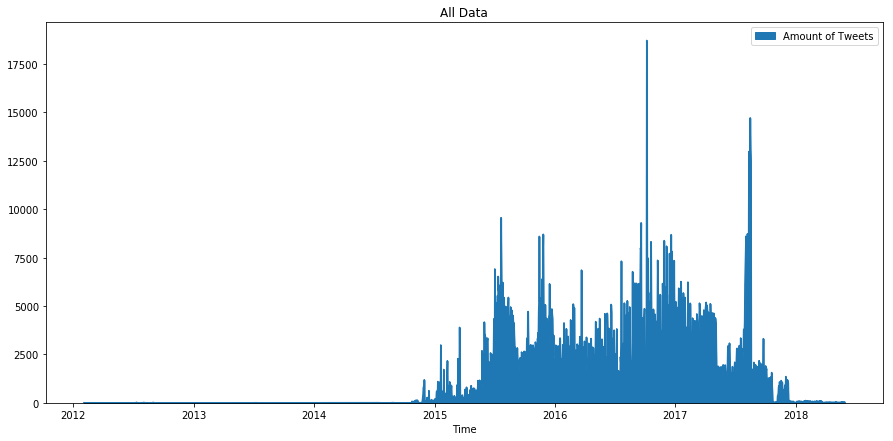

In [13]:
# Complete histogram
_ = histogram(all_data_df, "All Data")
plt.show()

This histogram represents the number of tweets emitted by the IRA over time. It gives good insight on the span of tweets. The first tweets appear in late 2012 and the max is reached during the US presidential campaign. The decay is assumed to be due to the discovery of these accounts.

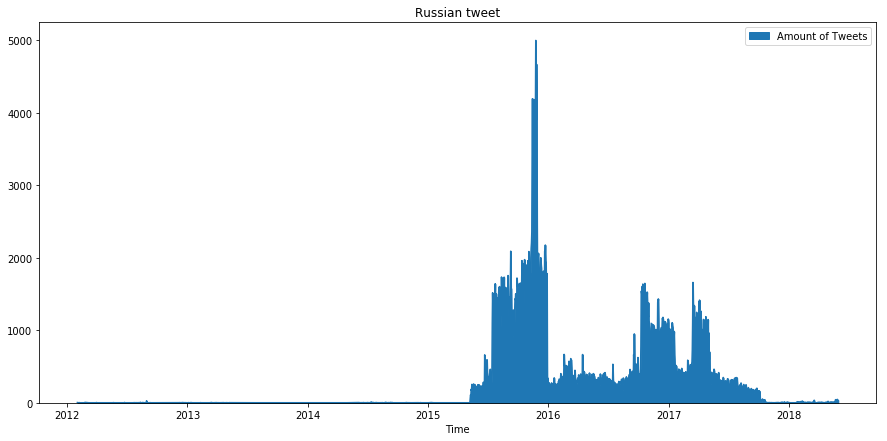

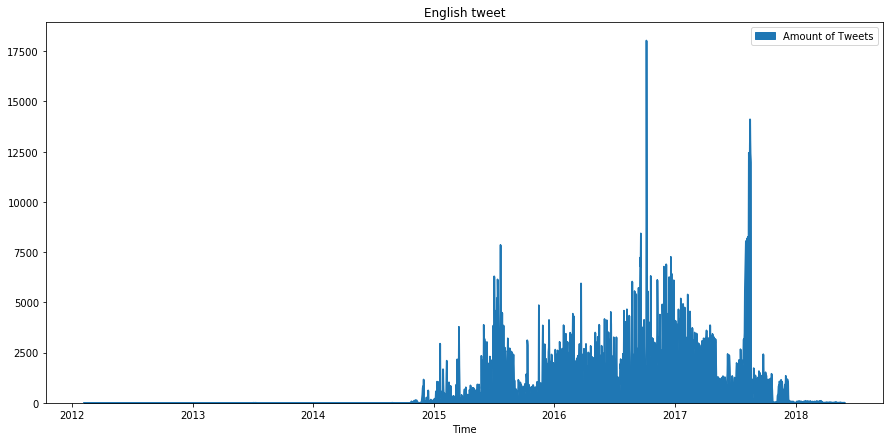

In [8]:
russian_tweet = all_data_df[all_data_df.language == 'Russian']
english_tweet = all_data_df[all_data_df.language == 'English']
_ = histogram(russian_tweet, "Russian tweet")
_ = histogram(english_tweet, "English tweet")
plt.show()

Tweets by language:
We can see that the IRA tried to influence the american elections but also made russian trolls, probably for national use. For exemple, we observe a big peak in russian tweets around the MH17 incident.

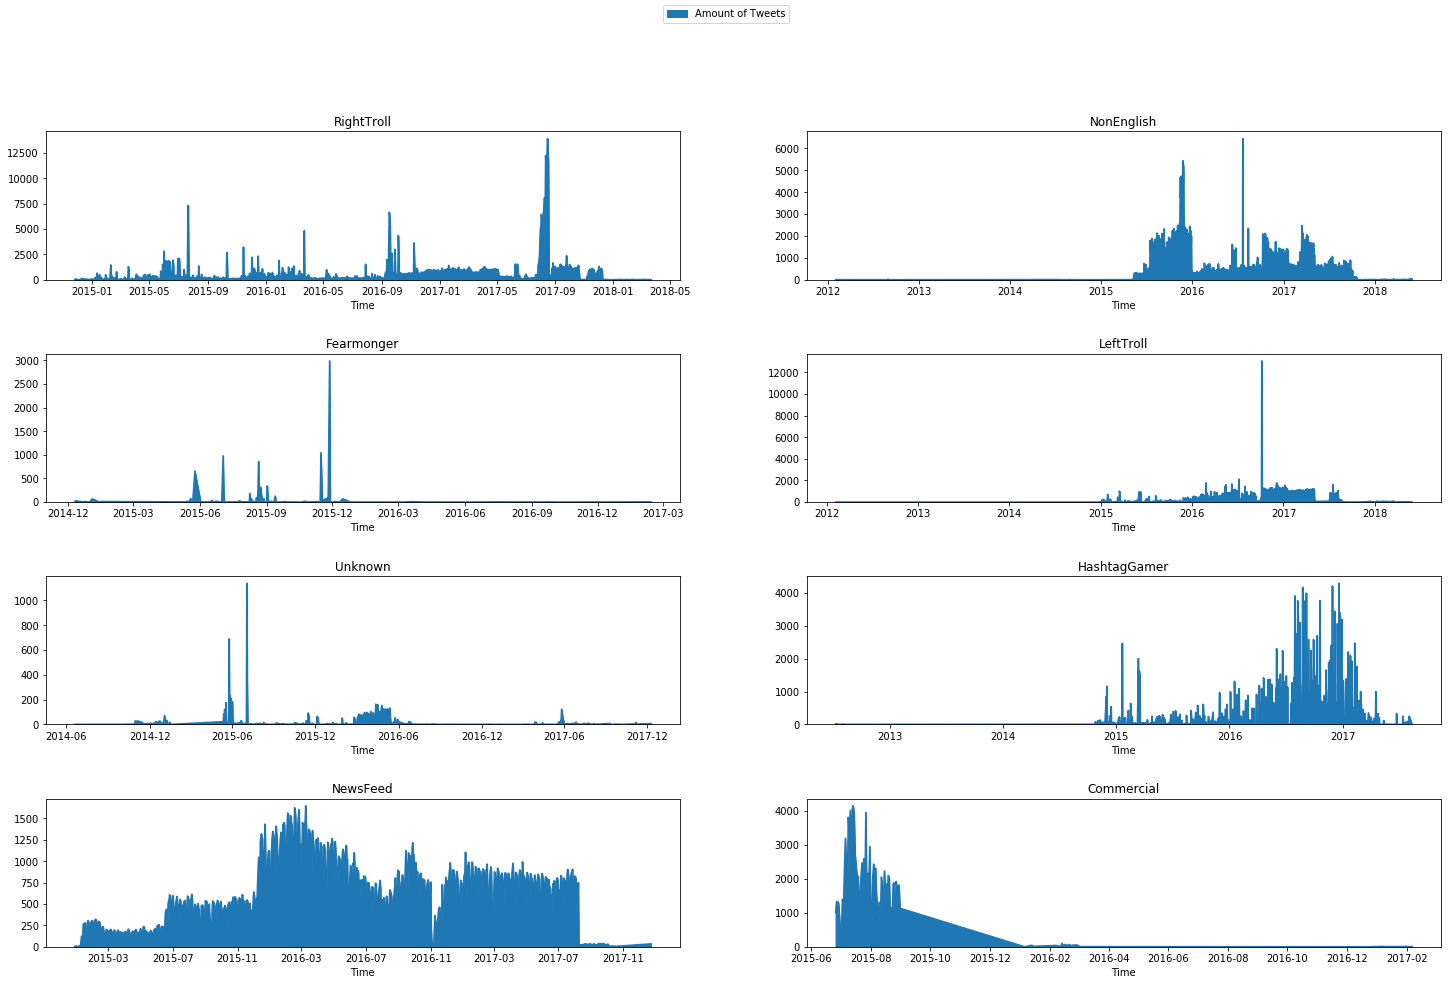

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2)
for (index, cat) in enumerate(account_categories):
    ax = axes[int(index/2), index%2]
    histogram(all_data_df, cat, cat, (25, 15), ax=ax)
    ax.get_legend().remove()

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.5)
plt.show()

In the dataset, tweets are organized by category. To get a better insight on these, we plot the distribution of tweets per category. 
The categories describe the type of people targeted by the accounts.

## Right Trolls

These are tweets and retweets from accounts created to impersonate republicans and promote Trump. We plotted below the most used hashtags from these accounts.

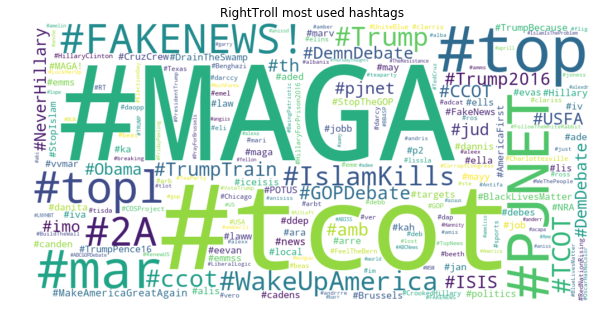

In [10]:
hashtag_graph(all_data_df, "RightTroll")

#MAGA: Make America Great Again
#tcot: Top Conservatives On Twitter
#PJNET: Patriot Journalist Network

Others: #NeverHillary, #ISIS, #WakeUpAmerica, #iceisis

## Left Trolls

These are tweets and retweets from accounts created to impersonate democrats supporters and promote Hillary. We will see later that these trolls promoted Hillary Clinton until only to help her win against Bernie Sanders and stopped after that. We plotted below the most used hashtags from these accounts.



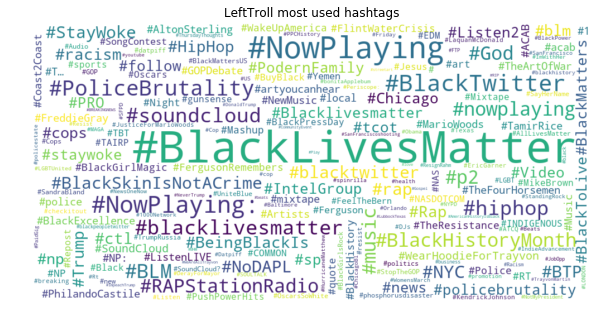

In [11]:
hashtag_graph(all_data_df, "LeftTroll")

### Imitating real users

In order to look like real users, we can see that the russians also used many commonly used hashtag.

For exemple, #NowPlaying was used a lot and often found with '#hiphop', '#RAPStationRadio', '#rap', '#music', '#power1044fm.com', '#HipHop', '#checkitout', '#EDM', '#Rap', '#HouseMusic', '#RnB', '#NewMusic', '#Reggae', '#ListenLive', '#HOuseMusic', '#Pop', '#TheIndieHour'

## Gamer trolls

Some "gamer" accounts were created where most tweets and hashtags imitate really well theses communities.



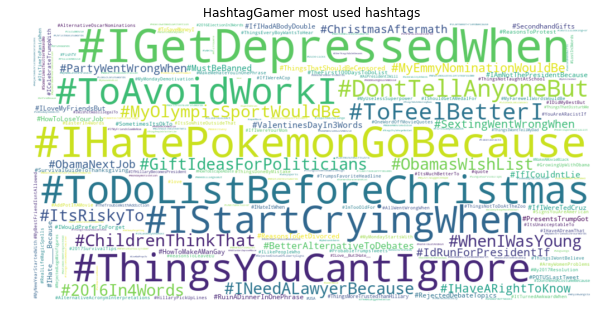

In [23]:
hashtag_graph(all_data_df, "HashtagGamer")

### Gamer retweeting tweets against Democrats

In [31]:
keywords = ["Clinton", "Hillary", "Democrats", "Obama"]
tweets = get_tweets(all_data_df, "HashtagGamer", keywords=keywords, retweets_only=True)
for (tweet, nb) in collections.Counter(tweets).most_common(20):
    print("'{0}' => RETWEETED {1} times".format(tweet, nb))

'We have been saying. Now confirmed publicly.  Obamacare was profitable for some insurers despite public comments https://t.co/e6L4qxtTHQ' => RETWEETED 21 times
'Voting For Hillary  #LostIn3Words' => RETWEETED 21 times
'#DontTellAnyoneBut Hillary's Password is Monica666' => RETWEETED 20 times
'#LostIn3Words ✔ Religion of peace  ✔ Hillary for President  ✔ Islam was hijacked' => RETWEETED 20 times
'Andrew Levine: "I would have rather bathed in vomit than voted for Hillary Clinton." https://t.co/bZuhg50NDK' => RETWEETED 19 times
'#ToDoListBeforeChristmas conclude that search for Obama's birth certificate before it becomes completely irrelevant' => RETWEETED 19 times
'Anyone voting Clinton #LostIn3Words' => RETWEETED 19 times
'Hillary Clinton emails #ThingsYoucantIgnore' => RETWEETED 17 times
'#2016ElectionIn3Words  Hillary for Prison' => RETWEETED 17 times
'#3WordHillary  Hail Queen Hydra!' => RETWEETED 17 times
'Any Clinton donor #MustBeBanned' => RETWEETED 17 times
'Here Comes Hillary #

### Evolution of usage of key hashtags over time, aggregated by week

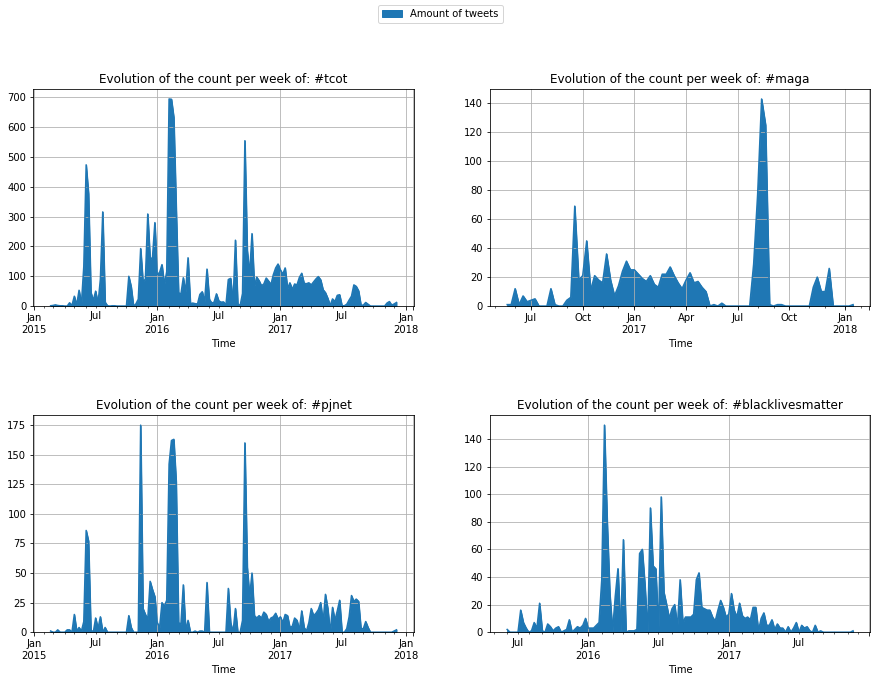

In [42]:
hashtag_over_time=["#tcot", "#maga", "#pjnet", "#blacklivesmatter"]

def get_numtweets_perweek(df,hashtag, ax=None):
    df["publish_date"]= df["publish_date"].apply(lambda x: pd.to_datetime(x))
    df = df.rename(columns={"publish_date":"Time"})
    tweets= df[df["content"].str.contains(hashtag)][["Time","content"]].groupby(pd.Grouper(key='Time', freq='W')).count()
    tweets = tweets.rename(columns ={"content":"Amount of tweets"})
    title = "Evolution of the count per week of: " + hashtag
    tweets.plot(figsize=(15,10),kind="area", title = title, grid=True, ax=ax)

fig, axes = plt.subplots(nrows=2, ncols=2)

for (index, h) in enumerate(hashtag_over_time):
    ax = axes[int(index/2), index%2]
    get_numtweets_perweek(all_data_df,h, ax)
    ax.get_legend().remove()

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.5)
plt.show()

We see that #pjnet and #tcot have some common trend tendencies. 

Something very interesting to notice is the decline for #blacklivesmatter after the win of Hillary Clinton against Bernie Sanders (July 2016). The russians probably tried to made her win against Sanders because they knew that Trump would have more chances against her.

We also see that the #maga (make america great again) started appearing only after Clinton won over Sanders, which confirms our initial theory.

## What's next? ##

For the next milestone, we aim to gain deeper understanding out of this dataset. We will study the retweet schemes (see how russian trolls made their tweets go popular, and what tweets they retweeted) to see if we can detect any strategies impletemented there. 

How are masterusers and retweeters connected? by account category? Is there some underlying hierarchy between them?
If we detect any interesting patterns there we will represent it visually with graphs.
We will also explore sentimental analysis to see if it can give us any extra insight on 